# Analysis of the Ground State of a NSM Hamiltonian

We want to understand if the Quasiparticle decomposition [CITE HERE PAPERS] of the NSM Hamiltonian can be easily implemented. In order to do that, we want to look at the component of a ground state of a Nucleus using the NSM representation. In this case, since the configuration space is small, we are going to study a p-shell Nucleus.

#### Imports

In [27]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
qq_filename='data/qq.p'
SPS=SingleParticleState(file_name=file_name)

#### Hyperparameters

In [32]:
nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

#### Set up of the Quantum Objects and computation of the ground state

In [33]:


# Compute the J^2 value
J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator

matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)
QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


# compute the NSM Hamiltonian
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])
if file_name=='data/cki':
    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
print('j_value=',J2Class.j_value(psi0))
print('deformation=',psi0.transpose().conjugate().dot(QQoperator.hamiltonian.dot(psi0)))




Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.44it/s]
592it [00:01, 508.15it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.88it/s]
1256it [00:02, 499.70it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.46it/s]


size= 12 6


1424it [00:02, 513.59it/s]


[-71.09941964]
total_m= [-1.51788304e-17]
(1, 1)
j_value= [[5.21804822e-15]]
deformation= [[-1.91306315]]


#### Analysis of the component of the Ground state

pr 8^Be= 0.16996616194196487 0.0196078431372549 



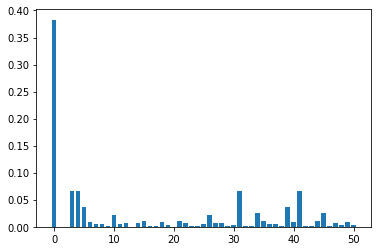

(51,)
(51, 1)
[[-67.58721777]]
(51, 1)
[[-50.08497251]]


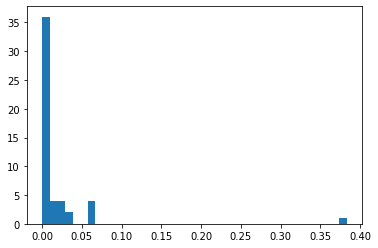

0.8568005818534806


In [37]:





# we need to get the argsort for
prob=(np.conj(psi0)*psi0)[:,0]

pr=np.sum(prob**2)
print('pr 8^Be=',pr,1/prob.shape[0],'\n')

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

print(prob.shape)
idx_sort=np.argsort(-1*prob[:])

cutoff_value=0.01
cutoff_prob=prob[prob>cutoff_value]


psi_cutoff=psi0.copy()
psi_cutoff[prob<cutoff_value]=0.
psi_cutoff=psi_cutoff/np.linalg.norm(psi_cutoff)
print(psi_cutoff.shape)
print(psi_cutoff.conj().T @ NSMHamiltonian.hamiltonian @ psi_cutoff)

psi_out=psi0.copy()
psi_out[prob>=cutoff_value]=0.
psi_out=psi_out/np.linalg.norm(psi_out)
print(psi_out.shape)
print(psi_out.conj().T @ NSMHamiltonian.hamiltonian @ psi_out)



plt.hist(prob,bins=40)
plt.show()

print(np.sum(cutoff_prob))
plt.show()



0.3828991120025859


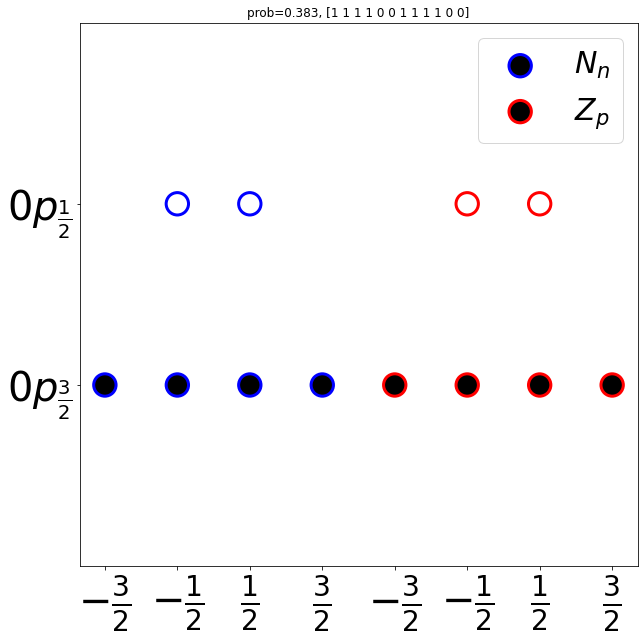

0.06552870783823214


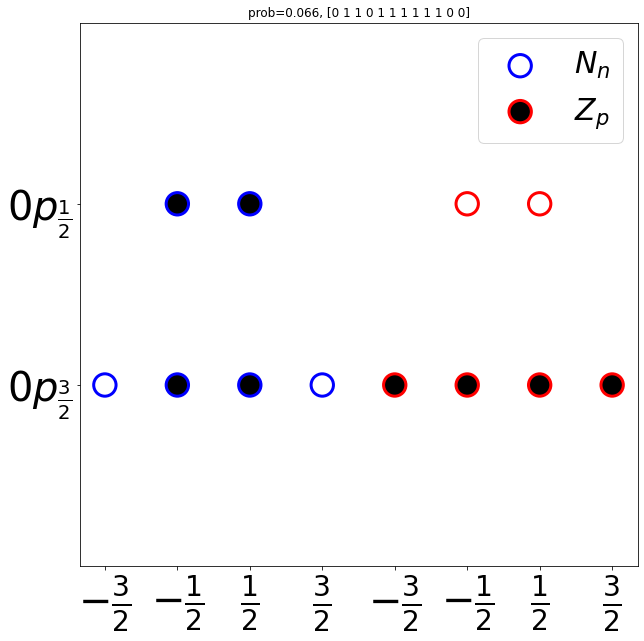

0.06552870783823211


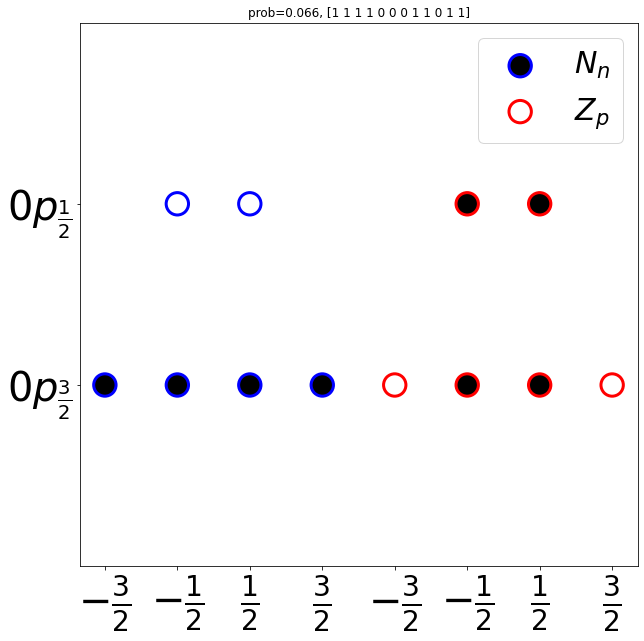

0.06552870783823209


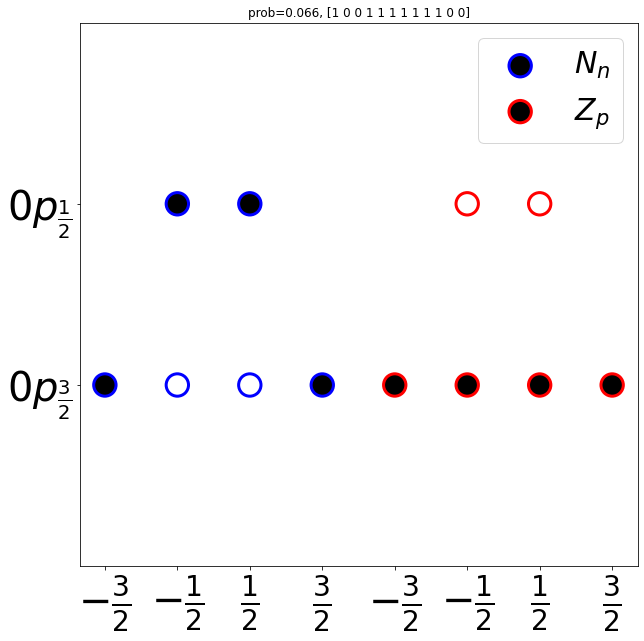

0.0655287078382319


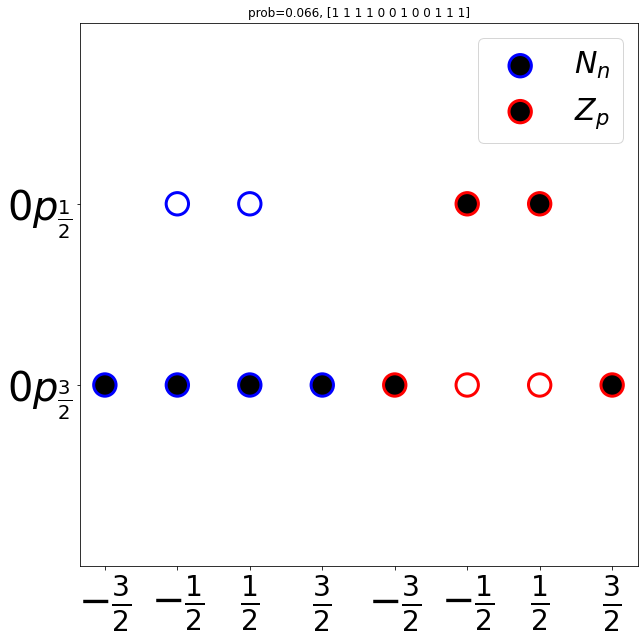

0.03614655413835593


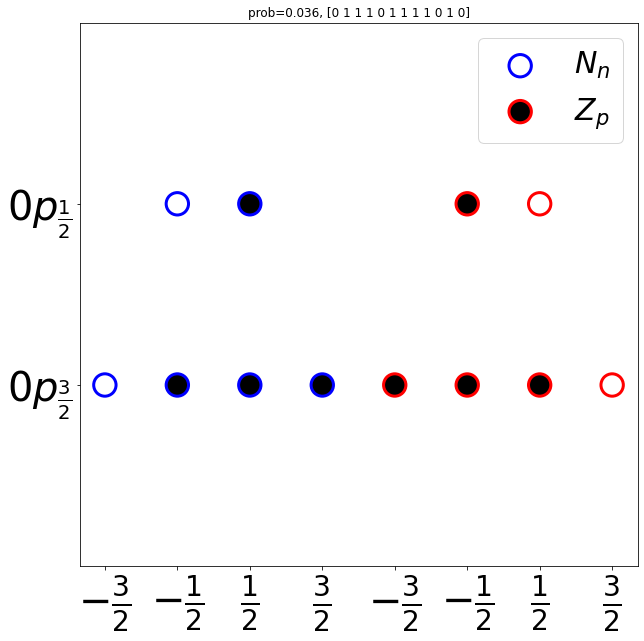

0.036146554138355824


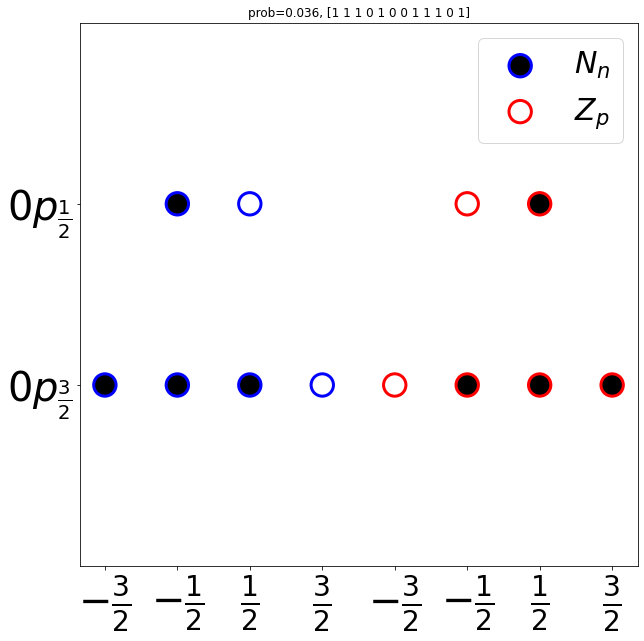

0.025009348315660308


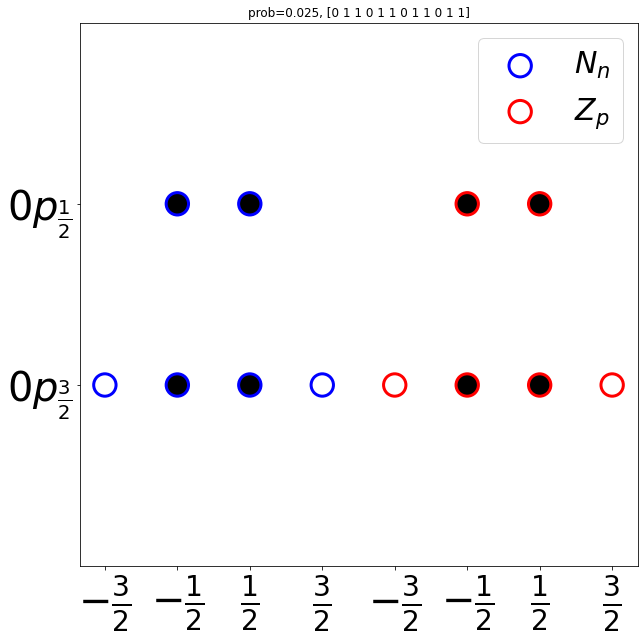

0.025009348315660263


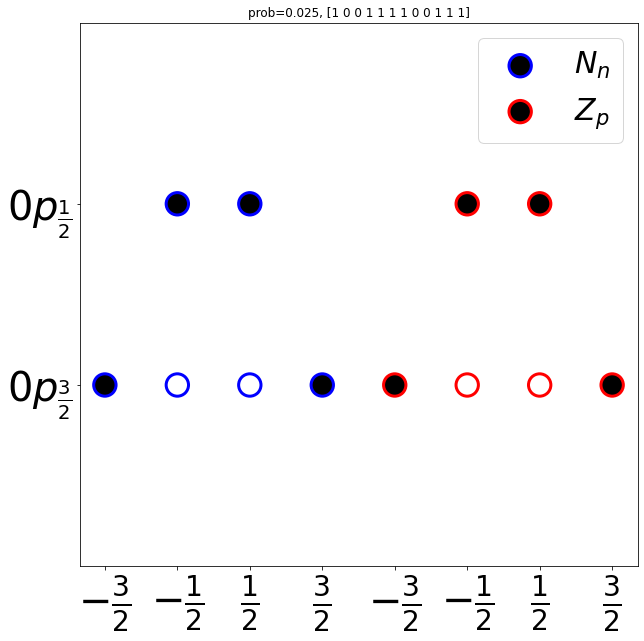

0.022112505728043876


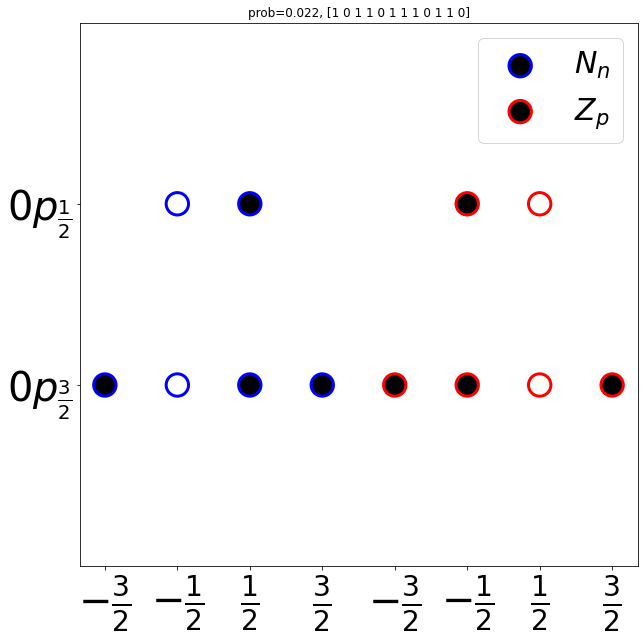

0.022112505728043866


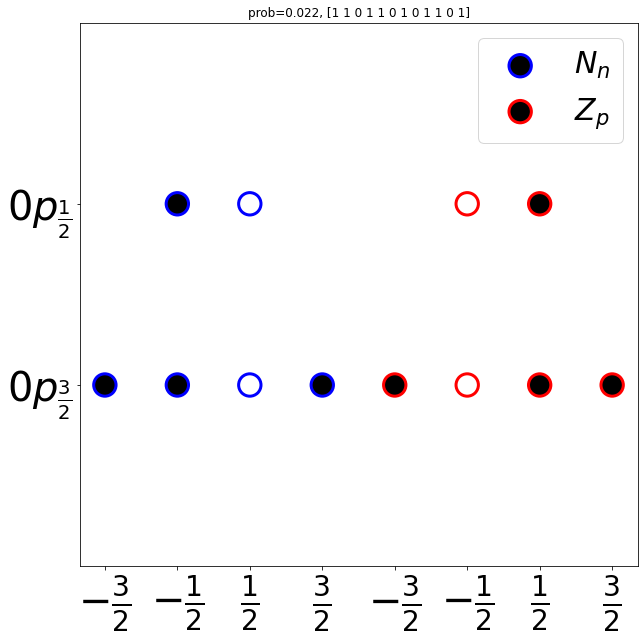

0.011509645148852039


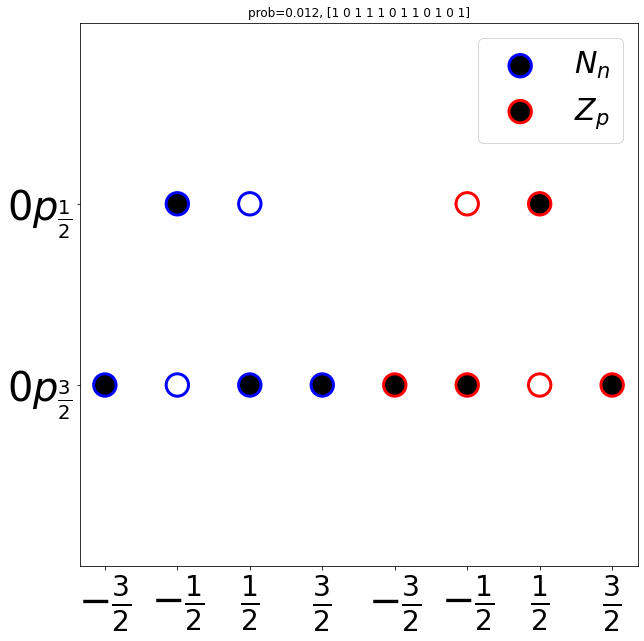

0.011509645148852018


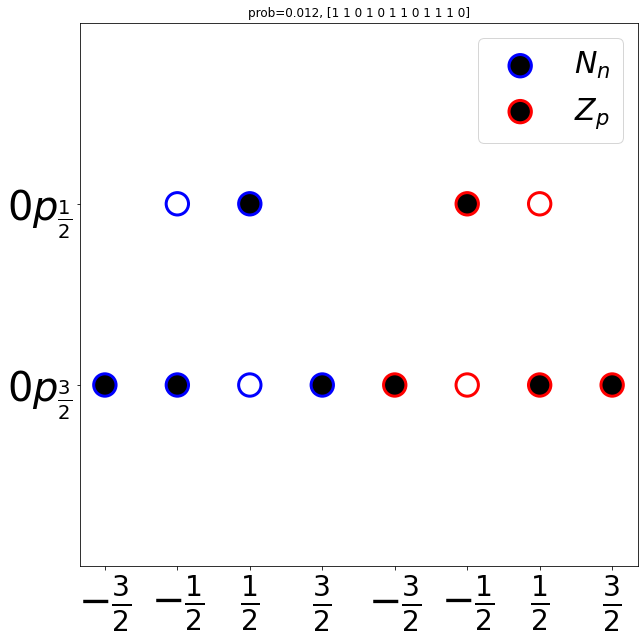

0.011115265918071236


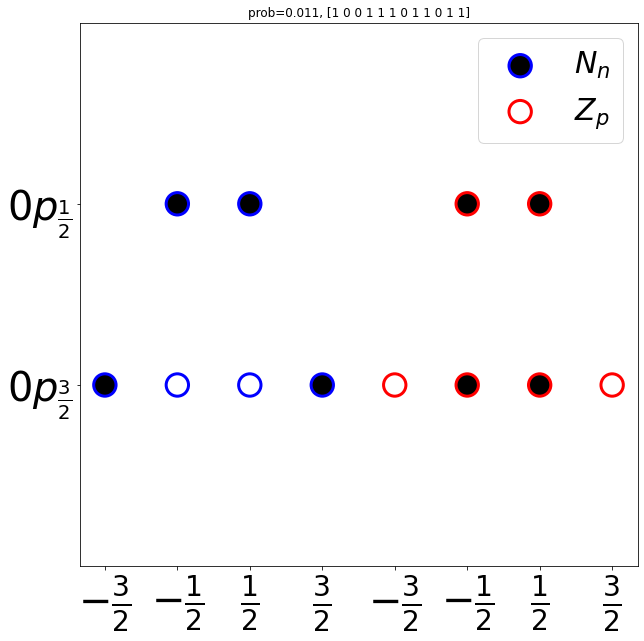

0.011115265918071198


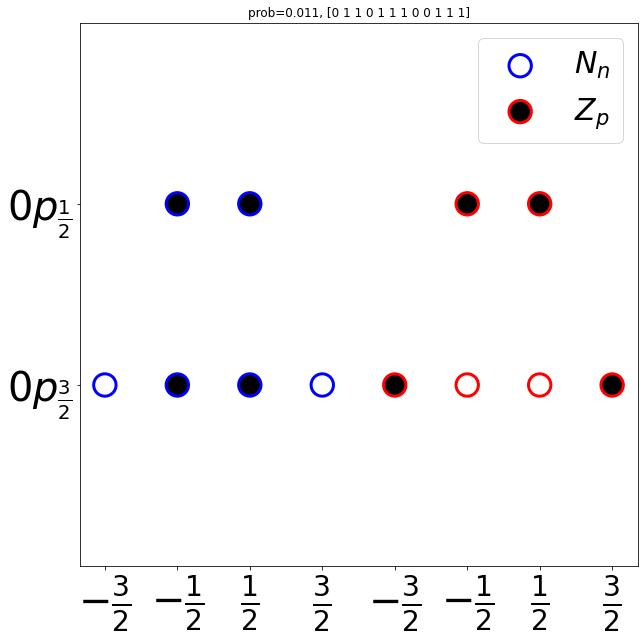

In [35]:



# coordinates of the basis points
x_coordinates=[ i for i in range(4)]+[i for i in range(1,3)]+[i for i in range(4,8)]+[i for i in range(5,7)]
y_coordinates=np.zeros(len(x_coordinates))
y_coordinates[4:6]=y_coordinates[10:12]=1
for i in idx_sort:
    
    if prob[i]>0.01:
        plt.figure(figsize=(10,10))
        plt.scatter(x_coordinates,y_coordinates,)
        print(prob[i])
        plt.title(f'prob={prob[i]:.3f}, {NSMHamiltonian.basis[i]}')
        plt.scatter(
            x_coordinates[:6],
            y_coordinates[:6],
            c=NSMHamiltonian.basis[i,:6],  # Colors determined by the array
            cmap='Greys',  # Colormap for coloring
            edgecolors='blue',  # Neutrons
            linewidth=3,  # Width of the edges
            s=500,  # Size of the points
            facecolor='none',  # No fill
            label=r'$N_n$'
        )
        plt.scatter(
            x_coordinates[6:],
            y_coordinates[6:],
            c=NSMHamiltonian.basis[i,6:],  # Colors determined by the array
            cmap='Greys',  # Colormap for coloring
            edgecolors='red',  # Protons
            linewidth=3,  # Width of the edges
            s=500,  # Size of the points
            facecolor='none',  # No fill
            label=r'$Z_p$'
        )
        plt.legend(fontsize=30)
        plt.yticks([0,1],[r'$0p_{\frac{3}{2}}$',r'$0p_{\frac{1}{2}}$'])
        plt.xticks([i for i in range(4)]+[i for i in range(4,8)],2*[r'$- \frac{3}{2}$',r'$- \frac{1}{2}$',r'$ \frac{1}{2}$',r'$\frac{3}{2}$'])
        plt.tick_params(which='major',labelsize=40)
        plt.ylim([-1,2])
        plt.show()
         

#### Comparison of different IPR computations

Imports

In [1]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/usdb.nat'
qq_filename='data/qq.sd'
SPS=SingleParticleState(file_name=file_name)

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Data loading

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/

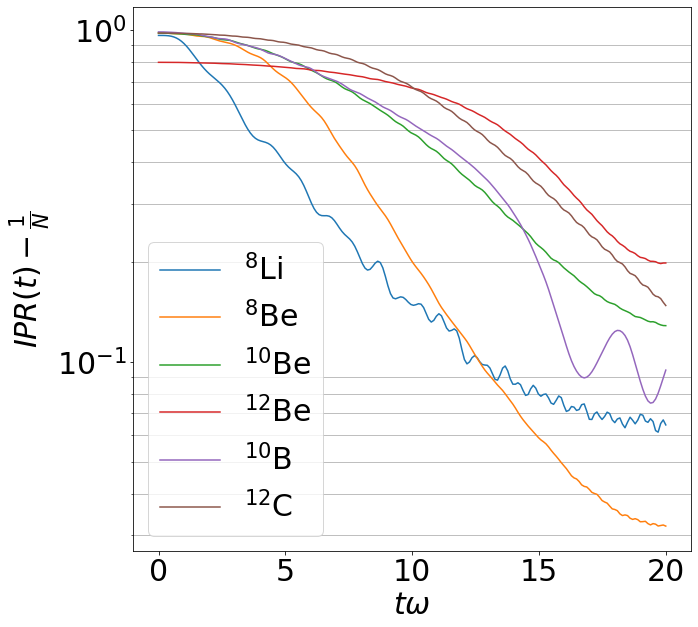

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/

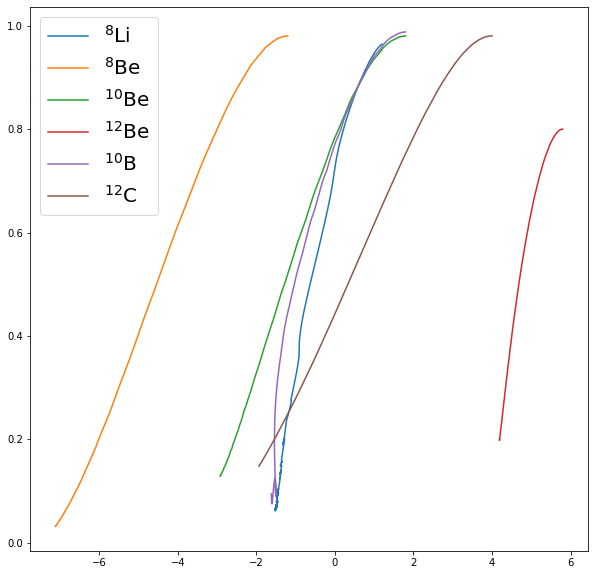

In [2]:
data=np.load('data/ipr_computation_pshell.npz')
### temporary
tf=20
time=np.linspace(0,tf,int(tf*10))
labels=data['labels']
iprs=data['ipr']
qqs=data['qq']
entanglement_pn=data['entropy_proton_neutron']
entanglement_initial=data['entropy_initial_rest']

plt.figure(figsize=(10,10))
for idx,ipr in enumerate(iprs):
    plt.plot(time,ipr,label=labels[idx])
    
plt.legend(fontsize=30)
plt.semilogy()
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$IPR(t)-\frac{1}{N}$',fontsize=30)
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30)
plt.grid(True,which='minor')

plt.show()

plt.figure(figsize=(10,10))
for i in range(len(labels)):
    plt.plot(qqs[i],iprs[i],label=labels[i])
plt.legend(fontsize=20)
plt.show()


Analysis of entanglement

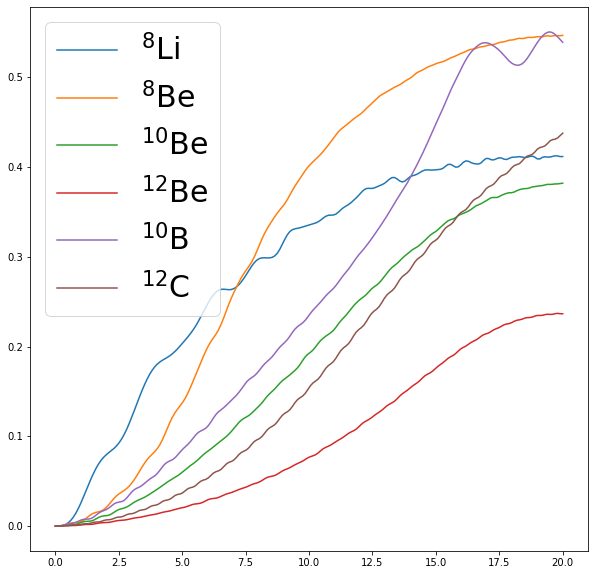

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(labels)):
    
    plt.plot(time,entanglement_pn[i]/np.log(2**6),label=labels[i])
plt.legend(fontsize=30)
plt.xlabel(r'$t \omega$',fontsize=30)
plt.ylabel(r'$S_{np}$',fontsize=30)
plt.show()